In [1]:
import numpy as np
from scipy.integrate import simps
import matplotlib.pyplot as plt

In [2]:
# --- Figure 3.6 --- #

# Computes part of the unoscillated reactor neutrinos flux at energy Enu (arXiv:1101.2663, arXiv:1411.6475).
def flux(Enu):
    
    # Isotope fractions and mean energies
    tf_iso = [0.58, 0.07, 0.3, 0.05] # U235, U238, Pu239, and Pu241
    ef_iso = [202.36, 205.99, 211.12, 214.26]
    
    # Parametrization coefficients
    a0 = [3.217, 4.833e-1, 6.413, 3.251]
    a1 = [-3.111, 1.927e-1, -7.432, -3.204]
    a2 = [1.395, -1.283e-1, 3.535, -1.428]
    a3 = [-3.69e-1, -6.762e-3, -8.82e-1, -3.675e-1]
    a4 = [4.445e-2, 2.233e-3, 1.025e-1, 4.254e-2]
    a5 = [-2.053e-3, -1.536e-4, -4.55e-3, -1.896e-3]
    
    # Calculating
    fator = 0.0
    fluxo = 0.0
    for i in range(4):
        fator += tf_iso[i]*ef_iso[i]
        fluxo += tf_iso[i] * np.exp(a0[i] + a1[i]*Enu + a2[i]*Enu**2.0 + a3[i]*Enu**3.0 + a4[i]*Enu**4.0 + a5[i]*Enu**5.0)
    
    fluxo = fluxo/fator
    return fluxo

In [3]:
# Computes the 3-flavor electron antineutrino survival probability P_surv including constant-density matter effects.
def Psurv_withme(Enu, L, t12, t13, t23, dm21, dm31, Ye, rho):
    
    # Converting mixing angles to radians
    t12 = np.deg2rad(t12)
    t13 = np.deg2rad(t13)
    t23 = np.deg2rad(t23)
    
    # Defining Δm²₃₂
    dm32 = dm31 - dm21
    
    # Sines and cosines of the mixing angles
    s2_t12 = np.sin(t12)**2
    c2_t12 = np.cos(t12)**2
    c_2t12 = np.cos(2.0*t12)
    s2_2t12 = np.sin(2.0*t12)**2
    s2_2t13 = np.sin(2.0*t13)**2
    c4_t13 = np.cos(t13)**4
    
    # Oscillation phases in vacuum
    d21 = 1.27e3*dm21*L/Enu
    d31 = 1.27e3*dm31*L/Enu
    d32 = 1.27e3*dm32*L/Enu
    s2_d21 = np.sin(d21)**2
    s2_d31 = np.sin(d31)**2
    s2_d32 = np.sin(d32)**2
    
    # Matter potential (constant density approximation)
    Acc = 1.52e-7*Ye*rho*Enu
    
    # Mixing angle θ₁₂ and Δm²₂₁ in matter (approximate)
    s2_t12m = s2_t12*(1.0 + 2.0*Acc*np.cos(t12)/dm21)
    c2_t12m = 1 - s2_t12m
    s2_2t12m = s2_2t12*(1.0 + 2.0*Acc*c_2t12/dm21)
    dm21m = dm21*(1 - Acc*c_2t12/dm21)
    d21m = 1.27e3*dm21m*L/Enu
    s2_d21m = np.sin(d21m)**2
     
    # Final expression for P_surv with matter effects
    prob = 1.0 - s2_2t12m*c4_t13*s2_d21m - s2_2t13*(c2_t12m*s2_d31 + s2_t12m*s2_d32)
    return prob

# Computes the JUNO-averaged electron antineutrino survival probability (Normal Ordering).
def Psurv_JUNO(Enu, t12, t13):
    
    # Reactor baselines to JUNO's main detector (L) in km
    L = [52.77, 52.77, 52.74, 52.82, 52.41, 52.49, 52.11, 52.19]
    
    # Reactor thermal powers in GWth
    W = [4.6, 4.6, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9]
    
    # Fixed parameters
    t23 = 48.5 # θ₂₃ best-fit value for the Normal Ordering [degrees] (arXiv:2410.05380)
    dm21 = 7.49e-5 # Δm²21 best-fit value for the Normal Ordering [MeV] (arXiv:2410.05380)
    dm31 = 2.534e-3 # Δm²31 best-fit value for the Normal Ordering [MeV] (arXiv:2410.05380)
    Ye = 0.5 # Electron fraction of the medium
    rho = 2.45 # Earth's typical matter density [g/cm³]
    
    # Arrays to store weights and individual survival probabilities
    fator = []
    prob_NO = []
    
    # Loop over all reactors
    for i in range(len(L)):
        # Geometrical + power weight
        fator.append(W[i]/(4*np.pi*L[i]**2))
        
        # Computing the weighted average survival probability
        prob_NO.append(Psurv_withme(Enu,L[i], t12, t13, t23, dm21, dm31, Ye, rho))
    
    # Converting to array and applying unit conversion factor
    fator = np.array(fator)*6.242e11
    prob_NO = np.array(prob_NO)
    
    sfator = sum(fator) # Term used to compute the "without oscillation" spectrum
    
    # Computing the weighted average survival probability
    prob_NO = sum(fator*prob_NO)
    
    return prob_NO, sfator

In [4]:
# Computes the expected reactor neutrino energy spectrum at JUNO for 6 years of data taking.
# Returns 4 spectra:
# - Without oscillation
# - With full oscillation (Normal Ordering)
# - With θ₁₂ = 0 (highlighting fast oscillation feature)
# - With θ₁₃ = 0 (highlighting slow oscillation feature)
def Spectrum():
    
    # Loading the precomputed associated antineutrino energy range and IBD effective cross-section for each bin
    enubins=np.load('junoenuspec.npy')
    sigbins=np.load('junosigspec.npy')
    
    # Initializing arrays
    sbins_osc_NO = np.zeros(len(enubins))
    sbins_osc_NO_t120 = np.zeros(len(enubins))
    sbins_osc_NO_t130 = np.zeros(len(enubins))
    sbins_no_osc = np.zeros(len(enubins))
    
    # Loop over reconstructed energy bins
    for i in range(len(enubins)):
        enn = enubins[i]
        
        # Temporary lists to accumulate spectra for this bin
        spectmp_osc_NO = []
        spectmp_osc_NO_t120 = []
        spectmp_osc_NO_t130 = []
        spectmp_no_osc = []
        
        # Loop over antineutrino energies inside the current bin
        for j in range(len(enubins[0])):
            enu = enn[j]
            
            # Computing flux at current energy
            fluxnu = flux(enu)
            
            # Calculating components for spectrum decomposition:
            fator = Psurv_JUNO(enu, 33.68, 8.52)[1] # Term used to compute the "without oscillation" spectrum
            pmed_NO = Psurv_JUNO(enu, 33.68, 8.52)[0] # Both oscillation parameters at their best-fit values (Normal Ordering)
            pmed_NO_t120 = Psurv_JUNO(enu, 0, 8.52)[0] # θ₁₂ = 0 → isolates fast oscillation (Δm²₃₁ and θ₁₃ driven)
            pmed_NO_t130 = Psurv_JUNO(enu, 33.68, 0)[0] # θ₁₃ = 0 → isolates slow oscillation (Δm²₂₁ and θ₁₂ driven)
            
            # Flux × probability × cross-section for each case
            spectmp_osc_NO.append(fluxnu * pmed_NO * sigbins[i][j])
            spectmp_osc_NO_t120.append(fluxnu * pmed_NO_t120 * sigbins[i][j])
            spectmp_osc_NO_t130.append(fluxnu * pmed_NO_t130 * sigbins[i][j])
            spectmp_no_osc.append(fluxnu * fator * sigbins[i][j])
            
        Np = 1.44e33 # Number of target protons
        eff = 0.822 # Detector efficiency
        t = 86400*365*6 # 6 years in seconds
        normaliz = Np*eff*t
        
        # Integrating over the antineutrino energy for current bin and for each case
        sbins_osc_NO[i] = normaliz*simps(spectmp_osc_NO, enn, even='avg')
        sbins_osc_NO_t120[i] = normaliz*simps(spectmp_osc_NO_t120, enn, even='avg')
        sbins_osc_NO_t130[i] = normaliz*simps(spectmp_osc_NO_t130, enn, even='avg')
        sbins_no_osc[i] = normaliz*simps(spectmp_no_osc, enn, even='avg')
    
    return sbins_no_osc, sbins_osc_NO, sbins_osc_NO_t120, sbins_osc_NO_t130

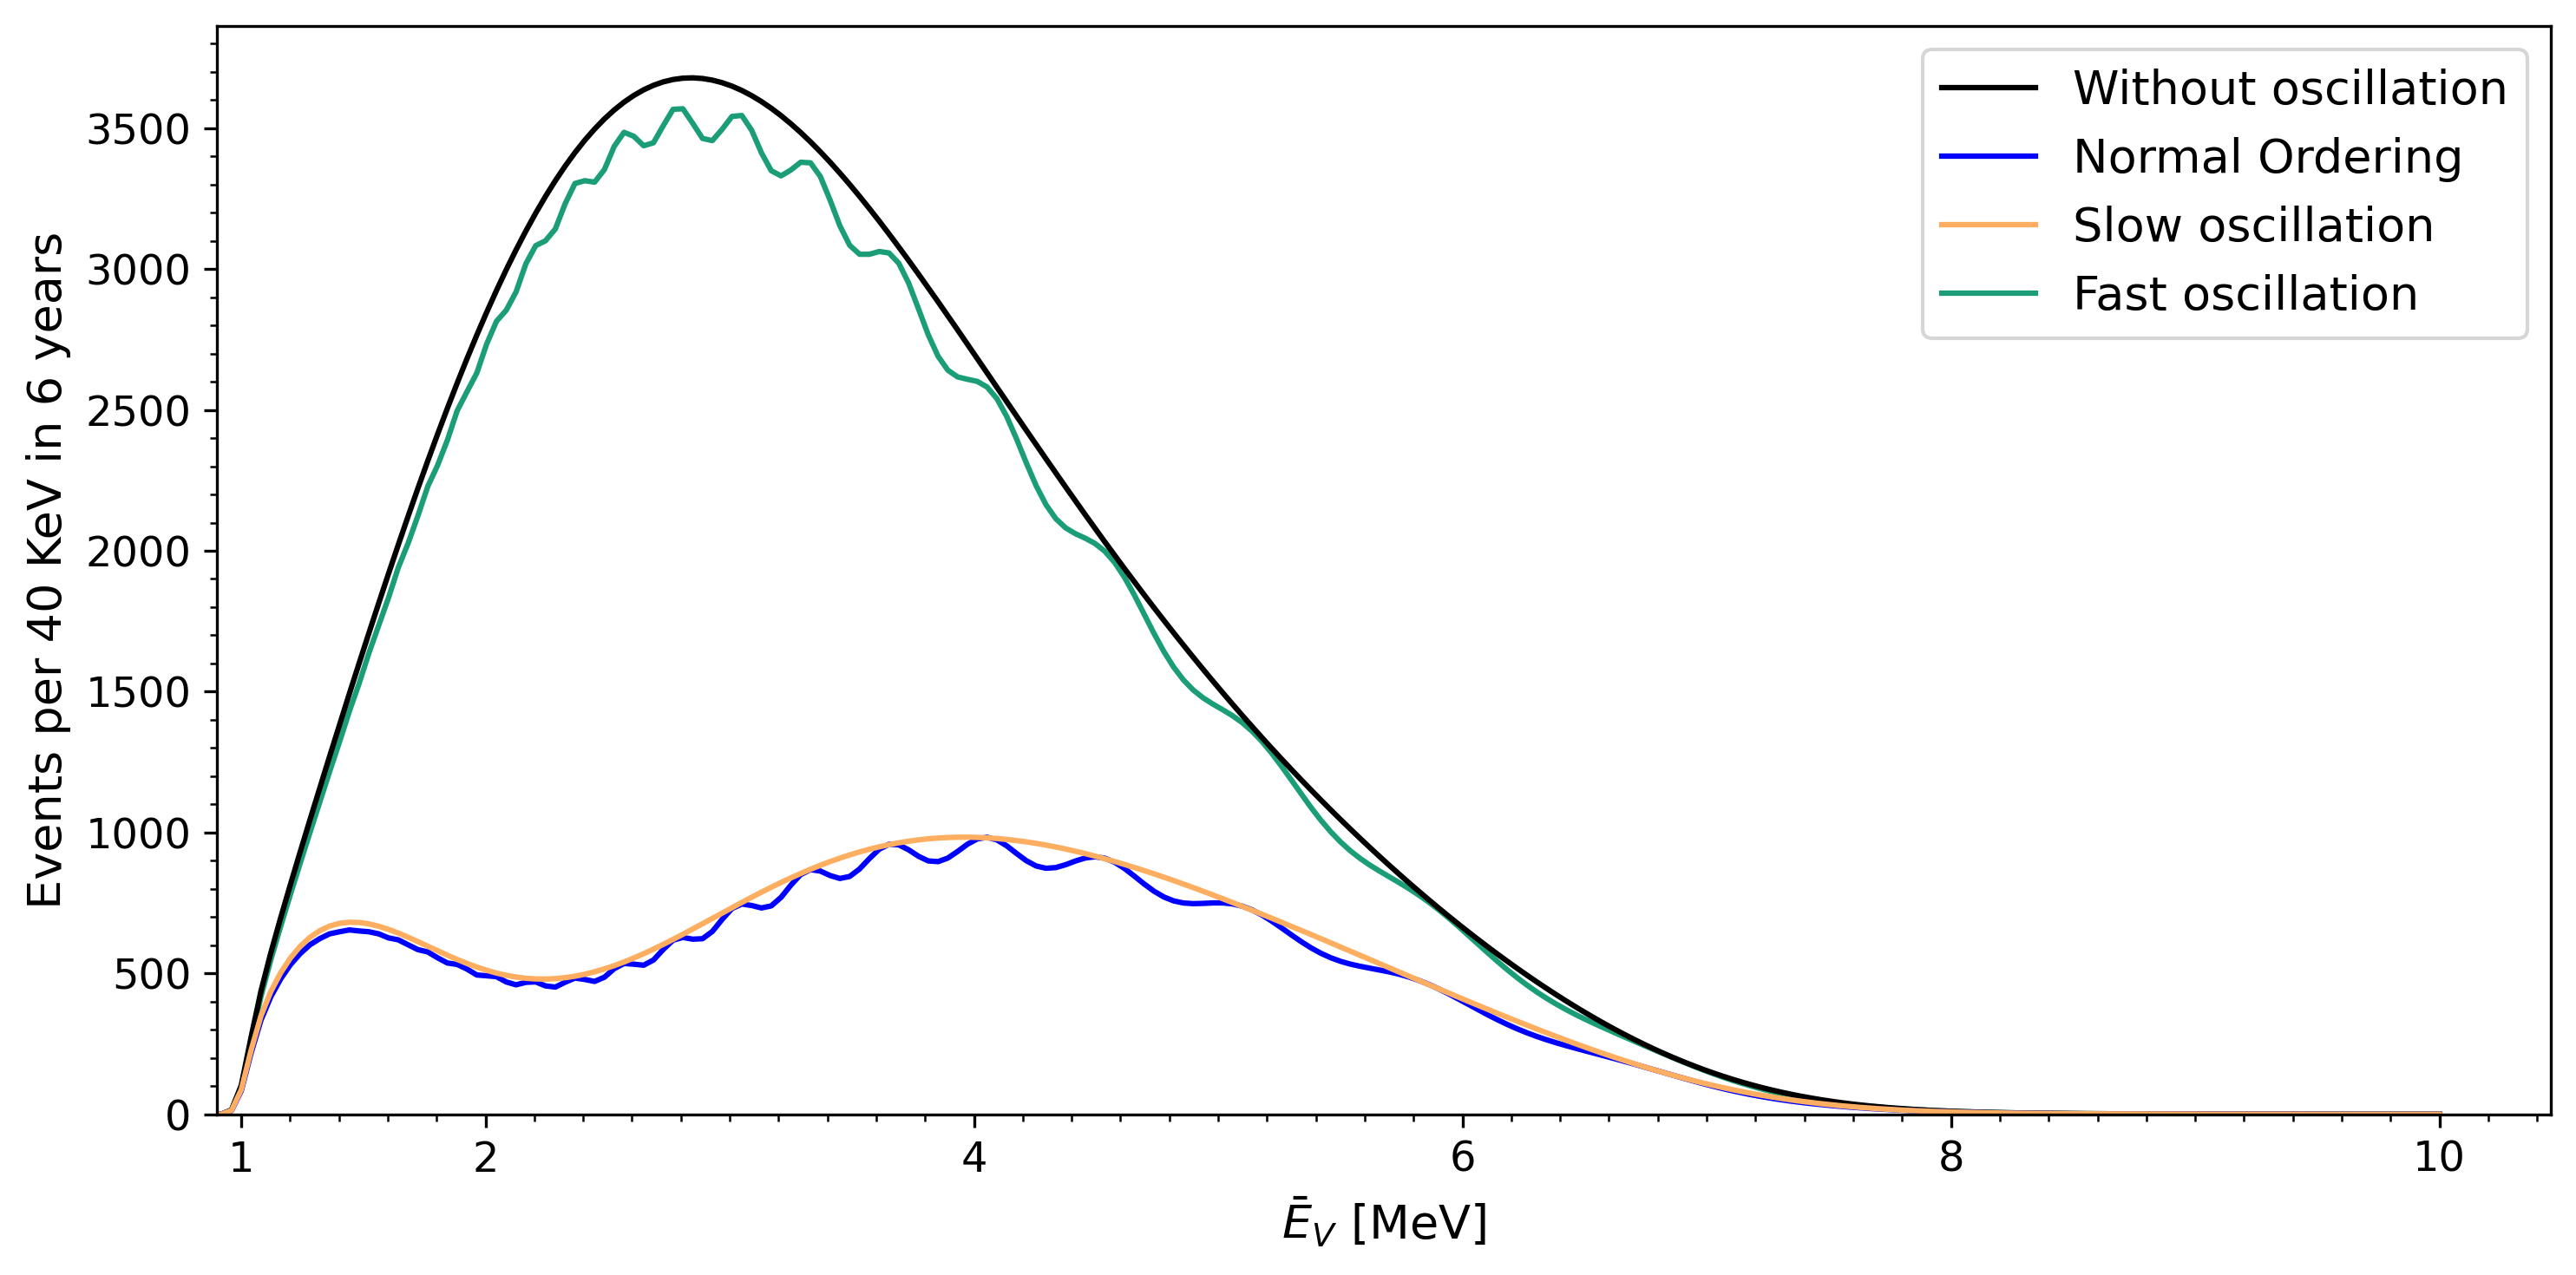

In [5]:
# Computing and storing the 4 spectra (no oscillation, full oscillation, fast-only, slow-only)
sbins_no_osc, sbins_osc_NO, sbins_osc_NO_t120, sbins_osc_NO_t130 = Spectrum()

# Reconstructed energy bin ranges [MeV]
evbins = np.linspace(0.88,10,228)

# Plotting
plt.figure(dpi = 300, figsize=(10,5))
plt.plot(evbins, sbins_osc_NO_t120, color = '#1B9E77', label = 'Fast oscillation')
plt.plot(evbins, sbins_no_osc, color = 'black', label = 'Without oscillation')
plt.plot(evbins, sbins_osc_NO, 'b', label = 'Normal Ordering')
plt.plot(evbins, sbins_osc_NO_t130, color = '#FDAE61', label = 'Slow oscillation')
plt.xlabel(r'$\bar{E}_V \ \text{[MeV]}$',fontsize = 13)
plt.ylabel('Events per 40 KeV in 6 years',fontsize = 13)
plt.xlim(0.9)
plt.xticks([1,2,4,6,8,10], fontsize = 11.5)
plt.yticks(fontsize = 11.5)
plt.ylim(0)
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,2,3,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize = 13)
plt.minorticks_on()
plt.tight_layout()
plt.show()